# Demonstration of surrogate model capabilities

This is a simple jupyter notebook to demonstrate the autogluon surrogate model capability.

Author: Soheyl Massoudi <smassoudi@ethz.ch>

# Step 1: Setup

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Step 2: Load and Convert Parquet Dataset

In [2]:
from datasets import load_dataset
import pandas as pd
import os

# Specify the directory and file path
csv_directory = "./data"
csv_file_name = "airfoil_data.csv"
csv_path = os.path.join(csv_directory, csv_file_name)
absolute_csv_path = os.path.abspath(csv_path)

# Create the directory if it doesn't exist
os.makedirs(csv_directory, exist_ok=True)

# Load dataset from Hugging Face
dataset = load_dataset("IDEALLab/airfoil_2d_v0", split="train")

# Convert to pandas DataFrame
df = pd.DataFrame(dataset)

# Save to CSV
df.to_csv(absolute_csv_path, index=False)

print(f"Dataset saved to {csv_path}")

/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset saved to ./data/airfoil_data.csv


In [3]:
dataset.column_names

['initial',
 'optimized',
 'mach',
 'reynolds',
 'cl_target',
 'area_target',
 'alpha',
 'area_initial',
 'cd_val',
 'cl_val',
 'cl_con',
 'area_con']

In [4]:
type(dataset['alpha'])

list

In [5]:
dataset['optimized'][1][0]

[1.0000194365938981,
 0.9897566593945221,
 0.9794544269870155,
 0.9691149136515305,
 0.9587402901643374,
 0.9483327419340516,
 0.9378945048481954,
 0.9274277968572291,
 0.9169348081262216,
 0.9064178020370062,
 0.8958790284346422,
 0.8853207187330372,
 0.8747448930482233,
 0.8641523083004454,
 0.8535437159737151,
 0.8429198967977035,
 0.8322817488654743,
 0.8216301200165563,
 0.8109658171290856,
 0.8002897285258235,
 0.7896027290487984,
 0.7789056461533759,
 0.7681993584263407,
 0.7574847603720507,
 0.7467626918304485,
 0.7360340279427758,
 0.7253037272659675,
 0.7145732743519277,
 0.7038473442473052,
 0.693126502752131,
 0.6824101435303259,
 0.6716976408464019,
 0.6609883248618159,
 0.6502815861483213,
 0.639576822934429,
 0.6288733614389102,
 0.6181705789840656,
 0.6074655520675161,
 0.5967516390819786,
 0.5860288162351749,
 0.5752975145222803,
 0.5645582221285628,
 0.5538114139478776,
 0.5430575344024076,
 0.5322970595788166,
 0.5215304770239737,
 0.5107583657552618,
 0.499988999525

# Step 3: Flatten columns and get X and Y datasets

In [6]:
def recursive_flatten(val):
    """
    Recursively flatten a nested list/tuple into a single list of values.
    E.g. [[x0, x1], [y0, y1]] -> [x0, x1, y0, y1].
    """
    if not isinstance(val, (list, tuple)):
        return [val]
    else:
        result = []
        for item in val:
            result.extend(recursive_flatten(item))
        return result

def flatten_list_columns_nested(df: pd.DataFrame) -> pd.DataFrame:
    """
    For each column in `df` where the first row is a list,
    recursively flatten that column and expand into multiple new numeric columns.
    """
    import pandas as pd
    
    new_cols_list = []
    drop_cols = []
    
    for col in df.columns:
        first_value = df[col].iloc[0]
        # Check if the first row is a list/tuple --> likely all rows are lists
        if isinstance(first_value, (list, tuple)):
            # Flatten each row, store in a temporary list
            flattened_rows = [recursive_flatten(val) for val in df[col]]
            # Ensure consistent length across rows
            lengths = [len(row) for row in flattened_rows]
            unique_lengths = set(lengths)
            if len(unique_lengths) > 1:
                raise ValueError(
                    f"Column '{col}' has rows of varying lengths {unique_lengths}. "
                    "Cannot flatten consistently without special handling."
                )
            # Create new DataFrame with columns [col_0, col_1, ..., col_(n-1)]
            n = lengths[0]
            new_col_names = [f"{col}_{i}" for i in range(n)]
            expanded_df = pd.DataFrame(flattened_rows, columns=new_col_names)
            new_cols_list.append(expanded_df)
            drop_cols.append(col)
    
    if new_cols_list:
        # Drop original list-columns and concatenate new expanded columns
        df = pd.concat(
            [df.drop(columns=drop_cols).reset_index(drop=True)] + new_cols_list,
            axis=1
        )
    return df

# Flatten the nested list columns
df = flatten_list_columns_nested(df)


In [7]:
# The flattened columns for "optimized" will now appear as "optimized_0", "optimized_1", etc.
# Let's find all columns that start with "optimized_"
opt_cols = [col for col in df.columns if col.startswith("optimized_")]

# Or you can do them all if you know the exact count/structure

# Additional numeric columns we want
other_input_cols = ["mach", "reynolds", "alpha"]

# Combine them
feature_cols = opt_cols + other_input_cols

target_col = "cl_val"

# Create X and y
X = df[feature_cols].values
y = df[target_col].values


# Step 4: Split Inputs and Targets

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Suppose X is shape [n_samples, n_features], y is shape [n_samples]
# (Replace with your actual arrays from the flattened dataset.)

# 1) Split off test data (20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 2) Split the remaining into train and validation (25% of X_temp = 20% of total)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42
)

print(f"Train size: {X_train.shape}, Val size: {X_val.shape}, Test size: {X_test.shape}")

scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

# Optionally scale target as well
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()


Train size: (448, 387), Val size: (150, 387), Test size: (150, 387)


# Step 5: Define a Pytorch Dataset and Model

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

class TabularDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TabularDataset(X_train_scaled, y_train_scaled)
val_dataset   = TabularDataset(X_val_scaled,   y_val_scaled)
test_dataset  = TabularDataset(X_test_scaled,  y_test_scaled)

batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = torch.utils.data.DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
test_loader  = torch.utils.data.DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)


class SimpleRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super(SimpleRegressor, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)

input_dim = X_train_scaled.shape[1]  # Number of features
hidden_dim = 64
model = SimpleRegressor(input_dim, hidden_dim, output_dim=1)


criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

model.to(device)

num_epochs = 100
patience = 10  # Early stopping patience
best_val_loss = float("inf")
epochs_no_improve = 0

train_losses = []
val_losses = []

best_model_weights = None
best_epoch = 0

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0

    # --- Training Loop ---
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        predictions = model(X_batch).squeeze(-1)
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item() * X_batch.size(0)

    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # --- Validation Loop ---
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            predictions = model(X_batch).squeeze(-1)
            loss = criterion(predictions, y_batch)
            running_val_loss += loss.item() * X_batch.size(0)

    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)

    # Check for improvement
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_epoch = epoch
        epochs_no_improve = 0
        # Store best weights
        best_model_weights = model.state_dict()
    else:
        epochs_no_improve += 1

    print(f"Epoch {epoch+1}/{num_epochs} "
          f"- Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

    # Early stopping condition
    if epochs_no_improve >= patience:
        print(f"Validation loss has not improved for {patience} epochs. Stopping early.")
        break

# --- After training, restore the best weights ---
print(f"Best validation loss = {best_val_loss:.4f} at epoch {best_epoch+1}.")
if best_model_weights is not None:
    model.load_state_dict(best_model_weights)



Using device: mps
Epoch 1/100 - Train Loss: 0.7779, Val Loss: 0.6491
Epoch 2/100 - Train Loss: 0.5426, Val Loss: 0.5571
Epoch 3/100 - Train Loss: 0.4203, Val Loss: 0.4517
Epoch 4/100 - Train Loss: 0.3566, Val Loss: 0.5126
Epoch 5/100 - Train Loss: 0.2885, Val Loss: 0.3740
Epoch 6/100 - Train Loss: 0.2311, Val Loss: 0.3203
Epoch 7/100 - Train Loss: 0.2069, Val Loss: 0.3497
Epoch 8/100 - Train Loss: 0.1813, Val Loss: 0.2814
Epoch 9/100 - Train Loss: 0.1509, Val Loss: 0.2585
Epoch 10/100 - Train Loss: 0.1446, Val Loss: 0.2606
Epoch 11/100 - Train Loss: 0.1486, Val Loss: 0.2190
Epoch 12/100 - Train Loss: 0.1236, Val Loss: 0.1765
Epoch 13/100 - Train Loss: 0.1032, Val Loss: 0.2197
Epoch 14/100 - Train Loss: 0.1139, Val Loss: 0.1706
Epoch 15/100 - Train Loss: 0.0833, Val Loss: 0.1646
Epoch 16/100 - Train Loss: 0.0799, Val Loss: 0.1505
Epoch 17/100 - Train Loss: 0.0682, Val Loss: 0.1327
Epoch 18/100 - Train Loss: 0.0685, Val Loss: 0.1336
Epoch 19/100 - Train Loss: 0.0633, Val Loss: 0.1169
Epo

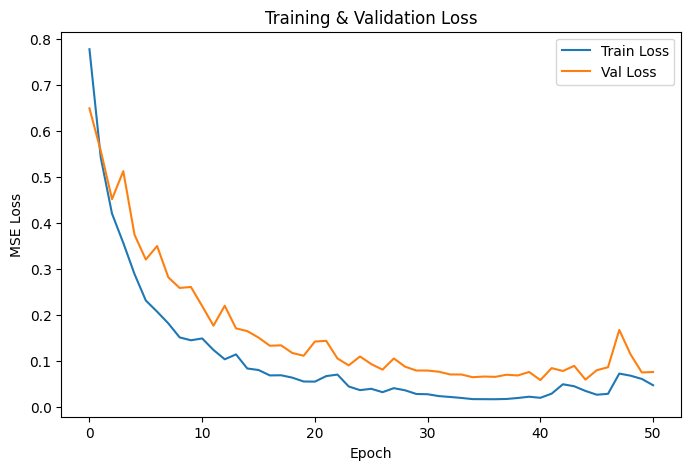

In [10]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.show()


# Step 6: Predictions and Inverse Transform

In [11]:
model.eval()
test_preds_scaled = []
test_targets_scaled = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        preds = model(X_batch).squeeze(-1)

        test_preds_scaled.append(preds.cpu().numpy())
        test_targets_scaled.append(y_batch.cpu().numpy())

test_preds_scaled = np.concatenate(test_preds_scaled)
test_targets_scaled = np.concatenate(test_targets_scaled)

# Inverse transform if you scaled the target
test_preds = scaler_y.inverse_transform(test_preds_scaled.reshape(-1, 1)).flatten()
test_targets = scaler_y.inverse_transform(test_targets_scaled.reshape(-1, 1)).flatten()

# Calculate the final test MSE or RMSE
mse_test = np.mean((test_preds - test_targets)**2)
rmse_test = np.sqrt(mse_test)
print(f"Test MSE:  {mse_test:.4f}")
print(f"Test RMSE: {rmse_test:.4f}")

# Display a small sample of true vs predicted
print("\nSample of predictions vs true values:")
for i in range(5):
    print(f"Predicted: {test_preds[i]:.4f},  True: {test_targets[i]:.4f},  Diff: {test_preds[i] - test_targets[i]:.4f}")


Test MSE:  0.0031
Test RMSE: 0.0561

Sample of predictions vs true values:
Predicted: 0.7420,  True: 0.7862,  Diff: -0.0443
Predicted: 0.9102,  True: 0.9167,  Diff: -0.0065
Predicted: 0.7486,  True: 0.7405,  Diff: 0.0082
Predicted: 0.8529,  True: 0.8399,  Diff: 0.0130
Predicted: 0.8227,  True: 0.8537,  Diff: -0.0310


In [12]:
# Step 1: Setup

In [17]:
from datasets import load_dataset
import pandas as pd
import os

# Specify the directory and file path
csv_directory = "./data"
csv_file_name = "airfoil_data.csv"
csv_path = os.path.join(csv_directory, csv_file_name)
absolute_csv_path = os.path.abspath(csv_path)

# Create the directory if it doesn't exist
os.makedirs(csv_directory, exist_ok=True)

# Load dataset from Hugging Face
dataset = load_dataset("IDEALLab/airfoil_2d_v0", split="train")

# Convert to pandas DataFrame
df = pd.DataFrame(dataset)

# Save to CSV
df.to_csv(absolute_csv_path, index=False)

print(f"Dataset saved to {csv_path}")



/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating test split: 100%|██████████| 47/47 [00:00<00:00, 21561.01 examples/s]


Dataset saved to ./data/airfoil_data.csv


In [2]:
import pandas as pd

# Load the dataset from Hugging Face's raw CSV URL
csv_url = "https://huggingface.co/datasets/IDEALLab/power_electronics_v0/resolve/main/dataset_v0_1.csv"

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(csv_url)

# Display the first few rows
print(df.head())

# Save it locally if needed
df.to_csv("./data/power_electronics_v0_1.csv", index=False)


         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  


In [32]:
type(df["initial_design"][0][1])


list

Type of df['initial_design'][0]: <class 'list'>
Type of first element (x coords): <class 'list'>
Type of second element (y coords): <class 'list'>


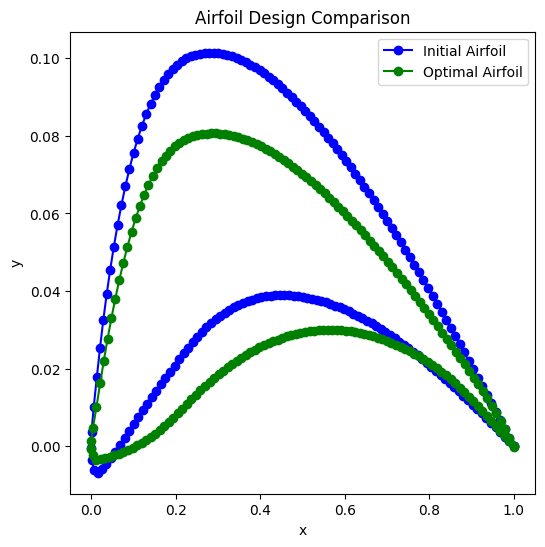

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Get the first entry for initial and optimal designs
init_design = df["initial_design"].iloc[0]
opt_design  = df["optimal_design"].iloc[0]

# Verify the structure:
print("Type of df['initial_design'][0]:", type(init_design))
print("Type of first element (x coords):", type(init_design[0]))
print("Type of second element (y coords):", type(init_design[1]))

# Pair x and y coordinates for initial and optimal designs
init_coords = np.column_stack((init_design[0], init_design[1]))
opt_coords  = np.column_stack((opt_design[0], opt_design[1]))

# Plot the designs
plt.figure(figsize=(6,6))
plt.plot(init_coords[:,0], init_coords[:,1], 'bo-', label="Initial Airfoil")
plt.plot(opt_coords[:,0], opt_coords[:,1], 'go-', label="Optimal Airfoil")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Airfoil Design Comparison")
plt.legend()
plt.show()


## Step 

## Step 2: Load surrogate model from engiopt

In [18]:
dataset.column_names

['initial_design',
 'optimal_design',
 'mach',
 'reynolds',
 'cl_target',
 'area_target',
 'alpha',
 'area_initial',
 'cd_val',
 'cl_val',
 'cl_con',
 'area_con']

In [ ]:
print(df.head())

         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  


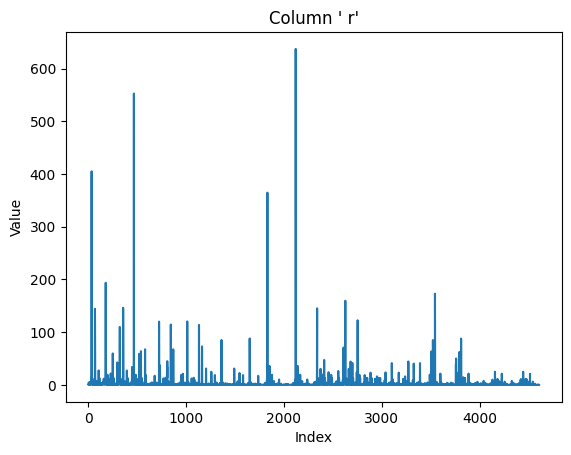

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline

df[' r'].plot(kind='line', title="Column ' r'")
plt.xlabel("Index")
plt.ylabel("Value")
plt.show()


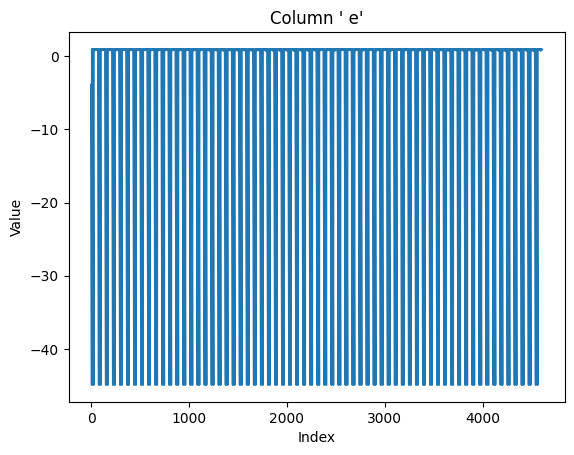

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

df[' e'].plot(kind='line', title="Column ' e'")
plt.xlabel("Index")
plt.ylabel("Value")
plt.show()


In [5]:
df.describe()


,C1,C2,C3,C4,C5,C6,L1,L2,L3,T1,g,r,e
count,4608.000000,4608.000000,4608.000000,4608.000000,4608.000000,4608.000000,4608.000000,4608.000000,4608.000000,4608.000000,4.608000e+03,4608.000000,4608.000000
mean,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000500,0.000500,0.000500,0.500000,1.779687e-01,2.548686,-5.418452
std,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.000500,0.000500,0.000500,0.258227,2.262546e-01,17.426358,12.806794
min,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.100000,7.770340e-07,0.004893,-44.932700
25%,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.300000,1.167198e-02,0.160791,-0.455450
50%,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000500,0.000500,0.000500,0.500000,6.475145e-02,0.409126,0.882925
75%,0.000020,0.000020,0.000020,0.000020,0.000020,0.000020,0.001000,0.001000,0.001000,0.700000,2.905664e-01,1.147634,0.950271
max,0.000020,0.000020,0.000020,0.000020,0.000020,0.000020,0.001000,0.001000,0.001000,0.900000,9.619789e-01,637.193300,0.992604


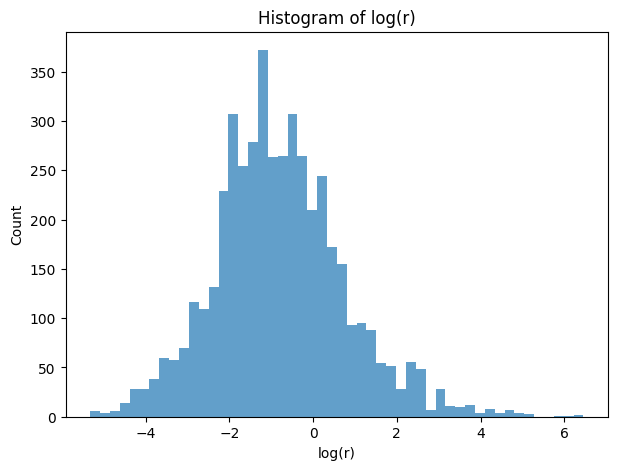

In [59]:
import numpy as np
import matplotlib.pyplot as plt

# Compute log(r + 1e-8)
log_r = np.log(df[' r'])

# Histogram
plt.figure(figsize=(7, 5))
plt.hist(log_r, bins=50, alpha=0.7)
plt.xlabel("log(r)")
plt.ylabel("Count")
plt.title("Histogram of log(r)")
plt.show()


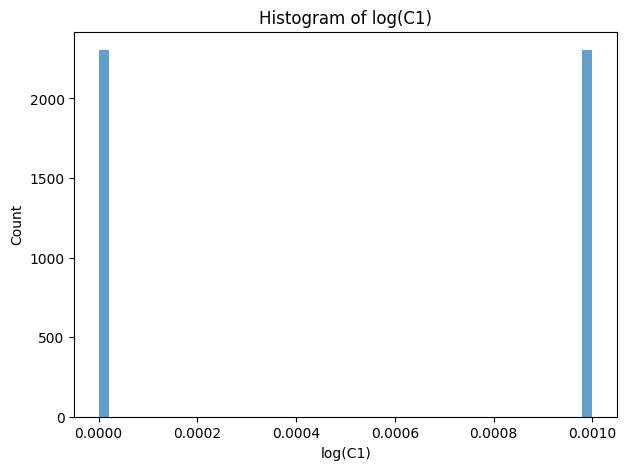

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Compute log(r + 1e-8)
log_r = df[' L3']

# Histogram
plt.figure(figsize=(7, 5))
plt.hist(log_r, bins=50, alpha=0.7)
plt.xlabel("log(C1)")
plt.ylabel("Count")
plt.title("Histogram of log(C1)")
plt.show()


In [19]:
df.columns

Index(['C1', ' C2', ' C3', ' C4', ' C5', ' C6', ' L1', ' L2', ' L3', ' T1',
       ' g', ' r', ' e'],
      dtype='object')

In [14]:
!python ./engiopt/shape2shape_leastV_vae.py \
    --data_dir "../EngiOpt/data" \
    --data_input "power_electronics_v0_1.csv" \
    --init_col "" \
    --opt_col "" \
    --target_col "r" \
    --log_target \
    --params_cols '["C1","C2","C3","C4","C5","C6","L1","L2","L3","T1", "g"]' \
    --nondim_map '{"C2": "C1", "C3": "C1", "C4": "C1", "C5": "C1", "C6": "C1", "L2": "L1", "L3": "L1"}' \
    --strip_column_spaces \
    --flatten_columns "[]" \
    --lambda_lv 1e-2 \
    --learning_rate 5e-5 \
    --no-structured \
    --hidden_layers 3 \
    --hidden_size 64 \
    --latent_dim 8 \
    --n_epochs 4000 \
    --batch_size 32 \
    --patience 500 \
    --scale_target \
    --no-track \
    --seed 18 \
    --save_model \
    --model_output_dir "my_models" \
    --test_model

Using device: mps
         C1        C2        C3        C4  ...   T1         g         r          e
0  0.000001  0.000001  0.000001  0.000001  ...  0.1  0.440126  0.914354  -3.903844
1  0.000001  0.000001  0.000001  0.000001  ...  0.2  0.410832  1.152453  -9.022484
2  0.000001  0.000001  0.000001  0.000001  ...  0.3  0.353193  1.521469 -14.144002
3  0.000001  0.000001  0.000001  0.000001  ...  0.4  0.256083  2.190335 -19.268402
4  0.000001  0.000001  0.000001  0.000001  ...  0.5  0.147918  3.205281 -24.395419

[5 rows x 13 columns]
Applied nondimensionalization using map: {'C2': 'C1', 'C3': 'C1', 'C4': 'C1', 'C5': 'C1', 'C6': 'C1', 'L2': 'L1', 'L3': 'L1'}
Applied log-transform to column 'r'
[Epoch 1/4000] Train Loss: 0.4053, Val Loss: 0.4019
[Epoch 2/4000] Train Loss: 0.3954, Val Loss: 0.3910
[Epoch 3/4000] Train Loss: 0.3826, Val Loss: 0.3762
[Epoch 4/4000] Train Loss: 0.3659, Val Loss: 0.3566
[Epoch 5/4000] Train Loss: 0.3455, Val Loss: 0.3344
[Epoch 6/4000] Train Loss: 0.3235, Val 

In [ ]:
[Epoch 200/200] Train Loss: 0.2139, Val Loss: 0.2389

In [30]:
import sys
import os

# Add the path to the directory containing your AutoGluon script
sys.path.append(os.path.abspath("../EngiOpt/engiopt"))

# Now you can import and use the script as if it's in the same directory
#from autogluon_multimodal import main


# CHECKED:

# data_dir
# data_input
# input_cols
# target_col
# flatten_columns
# hidden_layers
# activation
# optimizer
# learning_rate
# n_epochs
# batch_size
# patience
# scale_target
# wandb_project
# seed
# save_model
# track
# model_output_dir
# wandb_project



!python ./engiopt/shape2shape_leastV_vae.py \
    --data_dir "../EngiOpt/data" \
    --data_input "airfoil_data.csv" \
    --init_col "optimal_design" \
    --opt_col "optimal_design" \
    --target_col "cl_val" \
    --params_cols '["mach","reynolds","alpha"]' \
    --flatten_columns '["initial_design","optimal_design"]' \
    --lambda_lv 1e-2 \
    --learning_rate 1e-4 \
    --gamma 1.0 \
    --structured \
    --hidden_layers 3 \
    --hidden_size 32 \
    --latent_dim 8 \
    --n_epochs 50 \
    --batch_size 32 \
    --patience 40 \
    --scale_target \
    --no-track \
    --seed 18 \
    --save_model \
    --model_output_dir "my_models" \
    --test_model

Using device: mps
                                      initial_design  ...  area_con
0  [[0.9999864252928555, 0.9893170986509016, 0.97...  ...  0.832122
1  [[1.000000037209308, 0.9895321097704624, 0.979...  ...  0.887370
2  [[0.9999947929941965, 0.9893335711523464, 0.97...  ...  0.966670
3  [[0.9999964309108346, 0.9893222342558019, 0.97...  ...  0.938907
4  [[1.0000056013070746, 0.9893170615343417, 0.97...  ...  0.900123

[5 rows x 12 columns]
After flattening, df.columns: ['mach', 'reynolds', 'cl_target', 'area_target', 'alpha', 'area_initial', 'cd_val', 'cl_val', 'cl_con', 'area_con', 'initial_design_0', 'initial_design_1', 'initial_design_2', 'initial_design_3', 'initial_design_4', 'initial_design_5', 'initial_design_6', 'initial_design_7', 'initial_design_8', 'initial_design_9', 'initial_design_10', 'initial_design_11', 'initial_design_12', 'initial_design_13', 'initial_design_14', 'initial_design_15', 'initial_design_16', 'initial_design_17', 'initial_design_18', 'initial_design_